# Single-cell data denoising using Random Matrix Theory

Single-cell technologies offer a great potential to identify new cellular states, but the presence of "noise" and sparsity can obscure meaningful "signals". We aim to address the challenges of identifying biological signals from noisy single-cell sequencing data. To overcome these challenges, [L. Aparicio et. al.](https://doi.org/10.1016/j.patter.2020.100035) proposed a novel approach based on random matrix theory to denoise and analyze single-cell sequencing data. Their method utilizes the universality of global eigenvalue density predicted by random matrix theory of random covariance matrices to distinguish noise from the signals. Furthermore, they investigate the impact of sparsity on the generation of false signals in the data, which enhances the effectiveness of their proposed approach. At the end, we'll compare the efficacy of this approach with alternative techniques.

## Universal eigenvalue density of random matrices

Let us consider a matrix $X$ of dimension $N\times P$ whose entries are independent, identically distributed (i.i.d.) random variables with mean 0 and variance $\sigma^2 < \infty$, let: 

$$Y =  \frac{1}{P}X X^T$$

and let $\lambda_1,\, \lambda_2, \,\dots,\, \lambda_N$ be the eigenvalues of $Y$. $Y$ is known as covariance matrix.

Universality arises at the limit $N\to \infty$, $P\to \infty$, and $\gamma = \frac{N}{P}$ remains fixed. Then the limiting density of eigenvalues converges to Marchenko-Pastur distribution:
$$\rho(\lambda) = \frac{1}{2\pi \sigma^2 } \frac{\sqrt{(\lambda_{+} - \lambda)(x - \lambda_{-})}}{\gamma \lambda} \,\mathbf{1}_{x\in[\lambda_{-}, \lambda_{+}]}$$
with $ \lambda_{\pm} = \sigma^2(1 \pm \sqrt{\gamma})^2. $

The whole analysis is based on this assumption that the noise part of the data corresponds to the Marchenko-Pastur, the rest is signal.

## Loading the data

We'll us the data that was used by L. Aparicio et. al. in their example which was taken from Baron, M. et al. A single-cell transcriptomic map of the human and mouse pancreas reveals inter- and intra-cell population structure. Cell Syst. 3, 346–360.e4 (2016).

In [1]:
# load the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.linalg.blas as FB

# load the data

df = pd.read_table('example.txt')

In [2]:
df.head()

,Unnamed: 0,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AACSP1,AADAC,AADACL2,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,1,0,0,0,2,0,13,0,...,0,0,0,0,0,0,1,1,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,0,1
3,3,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,1
4,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


Let us fix the first column.

In [3]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AACSP1,AADAC,AADACL2,AADACP1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,2,0,13,0,0,...,0,0,0,0,0,0,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,0,1
3,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


Looks better now. Check the shape.

In [4]:
df.shape

(1459, 17287)

## Reducing sparsity : Removing the empty rows and columns

There are data from 1459 cells with possible 17287 genes. We can remove the cells that don't contain any gene and the genes that don't belong to any cell, if there is any. They are unnecessary and creates misleading "signals".

In [5]:
# make sure that all entries are numeric

set(df.dtypes.values)

{dtype('int64')}

In [6]:
# delete all empty rows and columns

cells = df.index[(np.sum(df, axis=1) > 0) & (np.count_nonzero(df, axis=1) >= 0)]
genes = df.columns[(np.sum(df, axis=0) > 0) & (np.count_nonzero(df, axis=0) >= 0)]
df = df.loc[cells, genes]
df.shape

(1459, 15601)

So, there were some genes that weren't available in any cells.

In [7]:
df

,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AADAC,AADACP1,AADAT,AAED1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,2,13,0,0,2,...,0,0,0,0,0,0,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,0,1
3,0,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1455,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1456,0,0,2,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1457,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Fitting the distribution to the Marchenko-Pastur(MP)

It's customery to convert the transcription values to transcription-per-million (TPM)

In [8]:
X = np.log2(1 + np.transpose(np.transpose(df.values)* 10**(6) / np.sum(df.values, axis=1)))

Diagonalize covariance matrix, find the eigenvalues, eigenvectors. For the matrix multiplication `X @ X.T` takes ~2 mins in our M1 Mac, whereas scipy's BLAS take only ~4s.

In [73]:
# shift and scale the data matrix
sc_X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0, ddof=0))
Y = (1/sc_X.shape[1]) * FB.dgemm(alpha=1.0, a=sc_X, b=sc_X, trans_b=True)

To get the eigenvalues and eigenvectors we can use `scipy.linalg.eigh()` method. Note that we didn't use the `eig()` method since `eigh()` is suitable particularly for hermitian or symmetric matrices.

In [74]:
# compute eigenvalues, eigenvectors

L, V = linalg.eigh(Y)

Plot the eigenvalue density

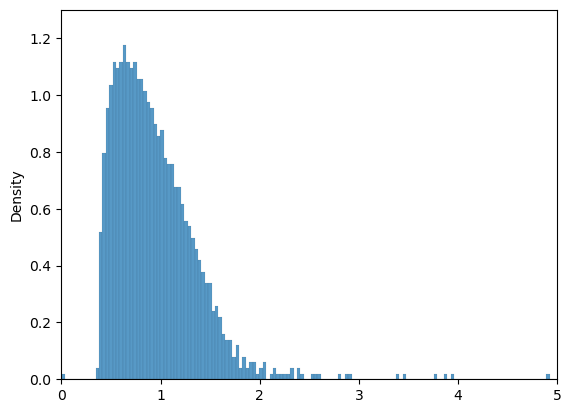

In [145]:
import seaborn as sns

sns.histplot(L, stat='density', bins=800)
plt.xlim(0, 5.0)
plt.ylim(0, 1.3)
plt.show()

Now we need to fit MP distribution to this density and figure out the outliers which would be considered as signals. For the rest of the analysis we'll load the codes provided by L. Aparicio et. al. We needed to modify a few things to make it work due to some dependency issues with their package. So we'll load it from local drive.

In [146]:
import sys
sys.path.append('<path to local, modified Randomly folder>')

In [147]:
import randomly

Load the data again.

In [148]:
df=pd.read_table('example.txt', index_col=0)

Initialize the process.

In [149]:
model = randomly.Rm()

In [150]:
model.preprocess(df, min_tp=0, 
                 min_genes_per_cell=0, 
                 min_cells_per_gene=0,
                 refined=False)

1459  cells and  15601  genes


`preprocess` does a few things. It removes all totally empty columns and rows. The `min_genes_per_cell` and `min_cells_per_gene` values could be set to something non-zero to get more popolated matrix. Keeping the `refined=False` at this moment.

In [151]:
model.fit()

Preprocessed data is being used for fitting


/Users/kazimbp/github_projects/Randomly_local/randomly-master/randomly/randomly.py:449: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(self.L,


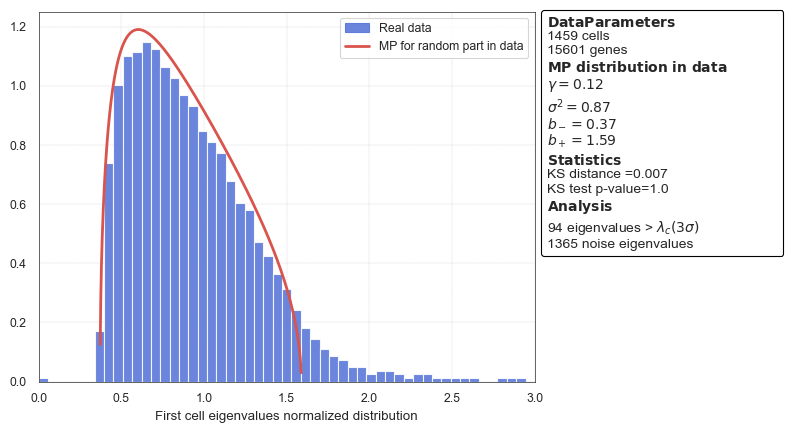

In [154]:
model.plot_mp(comparison=False)

The above plot shows the density of the real data and its MP-fit. If we assume the data represents the real picture of the situation, all eigenvalues on the right from the MP boundary are signals. Here we got 94 signal eigenvalues, 1365 noise. How about refining the data matrix for only reasonably expressed genes?

Run the refining function
1459  cells and  11701  genes
Preprocessed data is being used for fitting


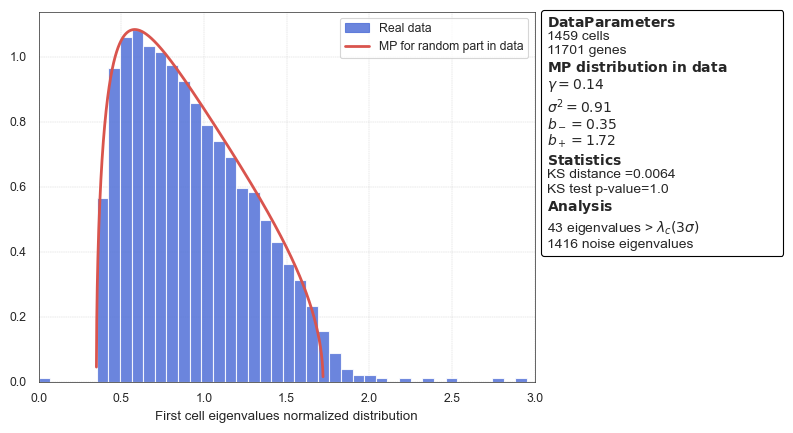

In [155]:
model2 = randomly.Rm()
model2.preprocess(df, min_tp=0, 
                 min_genes_per_cell=0, 
                 min_cells_per_gene=0,
                 refined=True)
model2.refining(min_trans_per_gene=6)
model2.fit()
model2.plot_mp(comparison=False)

Now we have less number of eigenvalues as signals. The reduction is due to suppressing the sparsity. It's well known in random matrix literature that sparsity takes eigenvalues outside of MP distribution, i.e. induces signals. But these signals do not have any biological significance. Hence we suppress them. We got only 43 eigenvalues as signal this time, almost half of the unrefined one. `min_trans_per_gene` value could be tuned to get suitable and meaningful noise-signal separation.

### Further analysis

Randomly allows us to perform t-SNE and k-means clustering. The difference between sparse and non-sparse signals is noticeable in the plots.

In [156]:
model.fit_tsne(sample_variance=350)

computing t-SNE, using Multicore t-SNE for 8 jobs
atribute embedding is updated with t-SNE coordinates


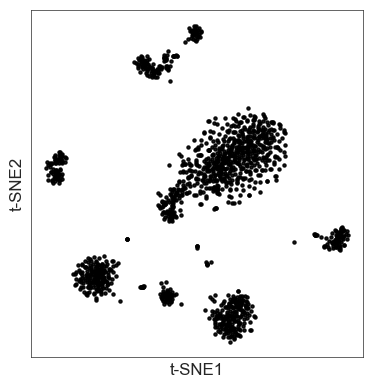

In [157]:
model.plot()

In [158]:
model2.fit_tsne(sample_variance=350)

computing t-SNE, using Multicore t-SNE for 8 jobs
atribute embedding is updated with t-SNE coordinates


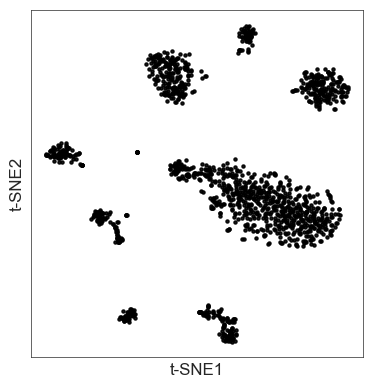

In [159]:
model2.plot()

In [161]:
model.fit_kmeans(n_clusters=16)
model2.fit_kmeans(n_clusters=16)

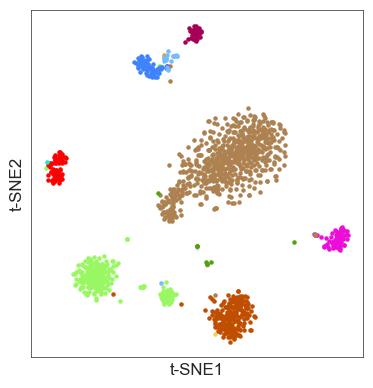

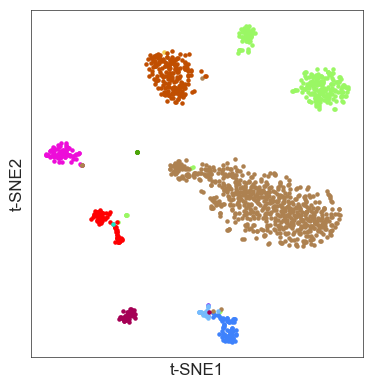

In [162]:
model.plot(labels=model.labels_kmeans)
model2.plot(labels=model.labels_kmeans)

Individual gene expressions could be visualized through t-SNE as well.

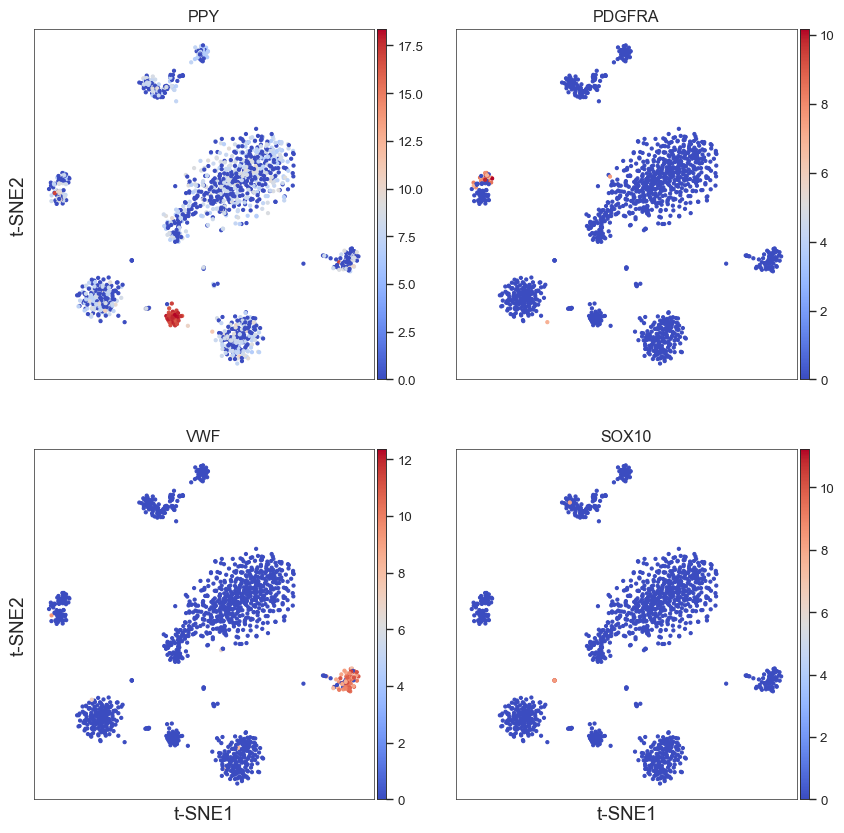

In [168]:
model.plot(gene=('PPY','PDGFRA','VWF','SOX10'), size=5)

For more info check out Randomly's example jupyter notebook.